# Import

In [1]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import math

In [2]:
ori_url = 'E:/[1]ASS_Data/static.txt' #[change to your own path]

# 0 Read data

In [3]:
ori_data = pd.read_csv(ori_url,sep='\t',low_memory=False)
ori_data.head(2)

,Row,Sample Name,Transaction Id,Anon Student Id,Session Id,Time,Time Zone,Duration (sec),Student Response Type,Student Response Subtype,...,KC (F2011).1,KC Category (F2011).1,KC (F2011).2,KC Category (F2011).2,School,Class,CF (oli:activityGuid),CF (oli:highStakes),CF (oli:purpose),CF (oli:resourceType)
0,1,All Data,2adbe4abefd649d48862d3f62b1abf5e,Stu_00b2b35fd027e7891e8a1a527125dd65,8dd109e680020ca6016f8e64290b5610,2011-09-21 17:26:36,US/Eastern,1,VIEW_PAGE,UI Event,...,NaN,NaN,NaN,NaN,Marion Technical College,MET2010B-01,NaN,NaN,NaN,NaN
1,2,All Data,4393251e32a6f00502f3f1ef894af8fe,Stu_00b2b35fd027e7891e8a1a527125dd65,8dd109e680020ca6016f8e64290b5610,2011-09-21 17:35:28,US/Eastern,23.13,ATTEMPT,NaN,...,NaN,NaN,NaN,NaN,Marion Technical College,MET2010B-01,NaN,NaN,NaN,NaN


In [4]:
ori_data.columns

Index(['Row', 'Sample Name', 'Transaction Id', 'Anon Student Id', 'Session Id',
       'Time', 'Time Zone', 'Duration (sec)', 'Student Response Type',
       'Student Response Subtype', 'Tutor Response Type',
       'Tutor Response Subtype', 'Level (Sequence)', 'Level (Unit)',
       'Level (Module)', 'Level (Section1)', 'Problem Name', 'Problem View',
       'Problem Start Time', 'Step Name', 'Attempt At Step', 'Is Last Attempt',
       'Outcome', 'Selection', 'Action', 'Input', 'Input.1', 'Feedback Text',
       'Feedback Classification', 'Help Level', 'Total Num Hints',
       'KC (Single-KC)', 'KC Category (Single-KC)', 'KC (Unique-step)',
       'KC Category (Unique-step)', 'KC (F2011)', 'KC Category (F2011)',
       'KC (F2011).1', 'KC Category (F2011).1', 'KC (F2011).2',
       'KC Category (F2011).2', 'School', 'Class', 'CF (oli:activityGuid)',
       'CF (oli:highStakes)', 'CF (oli:purpose)', 'CF (oli:resourceType)'],
      dtype='object')

# 1 Filtering, De-duplication and Time Sorting

In [5]:
# Filtering
select_columns = ["Anon Student Id","Problem Name","KC (F2011)","Outcome","Time"]
sel_data = ori_data[select_columns]
sel_data.head()
#sel_data.shape #:(361092, 5)

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
0,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,NaN,NaN,2011-09-21 17:26:36
1,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,identify_interaction,CORRECT,2011-09-21 17:35:28
2,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,gravitational_forces,CORRECT,2011-09-21 17:35:28
3,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_spring,INCORRECT,2011-09-21 17:35:28
4,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_cord,CORRECT,2011-09-21 17:35:28


In [6]:
# dropna
sel_data_copy = sel_data.copy()
sel_data_copy.dropna(inplace=True)
sel_data = sel_data_copy 
#sel_data.shape #shape: (152592, 5)

In [7]:
# drop_duplicates
sel_data = sel_data.drop_duplicates().reset_index(drop=True)
sel_data = sel_data.reset_index(drop=True)
#sel_data.shape #：(118856, 5)

In [8]:
# Group by 'Anon Student Id'and sort by' Time' within each group
sel_data['Time'] = pd.to_datetime(sel_data['Time'])
sel_data_sorted = (
    sel_data.sort_values(['Anon Student Id', 'Time'])
    .groupby('Anon Student Id')
    .apply(lambda x: x.sort_values(by='Time'))
    .reset_index(drop=True)
)
sel_data_sorted.head()

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
0,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,identify_interaction,CORRECT,2011-09-21 17:35:28
1,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,gravitational_forces,CORRECT,2011-09-21 17:35:28
2,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_spring,INCORRECT,2011-09-21 17:35:28
3,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_cord,CORRECT,2011-09-21 17:35:28
4,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,simple_step,CORRECT,2011-09-21 17:35:28


# 2.1 Remove students whose answers are less than or equal to 14 times

In [9]:
# all students
stu_list = sel_data_sorted['Anon Student Id'].value_counts().index.tolist()
len(stu_list) #:331

331

In [10]:
# students who answered less than or equal to 14 times
stu_times = sel_data_sorted['Anon Student Id'].value_counts()
rare_stu = stu_times[stu_times <= 14].index.tolist()
len(rare_stu) #:14

14

In [11]:
# remove students who answered less than or equal to 14 times
sel_data_sorted_1 = sel_data_sorted[~sel_data_sorted['Anon Student Id'].isin(rare_stu)]
sel_data_sorted_1 = sel_data_sorted_1.reset_index(drop=True)
sel_data_sorted_1.shape #：((118762, 5)

(118762, 5)

# 2.2 Remove questions answered less than or equal to 2 times

In [12]:
# all questions
exer_list = sel_data_sorted_1['Problem Name'].value_counts().index.tolist()
#len(exer_list) #:154

In [13]:
# questions answered less than or equal to 2 times.
exer_times = sel_data_sorted_1['Problem Name'].value_counts()
rare_exer = exer_times[exer_times <= 2].index.tolist()
#len(rare_exer) #:0

In [14]:
filtered_sel_data_sorted = sel_data_sorted_1.copy()

In [15]:
filtered_sel_data_sorted.head()

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
0,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,identify_interaction,CORRECT,2011-09-21 17:35:28
1,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,gravitational_forces,CORRECT,2011-09-21 17:35:28
2,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_spring,INCORRECT,2011-09-21 17:35:28
3,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,represent_interaction_cord,CORRECT,2011-09-21 17:35:28
4,Stu_00b2b35fd027e7891e8a1a527125dd65,_m2_assess,simple_step,CORRECT,2011-09-21 17:35:28


# 3 Mapping students, problems and knowledge points

In [15]:
# Get a list of students, questions and knowledge points.
stu_list = filtered_sel_data_sorted['Anon Student Id'].value_counts().index.tolist()
#len(stu_list)#: 317
problem_list = filtered_sel_data_sorted['Problem Name'].value_counts().index.tolist()
#len(problem_list)#: 154
kc_list = filtered_sel_data_sorted['KC (F2011)'].value_counts().index.tolist() 
#len(kc_list)#: 80

In [16]:
# initialize dic
stu_get_ID = {}
plm_get_ID = {}
kc_get_ID = {}
out_get_ID = {'CORRECT':1,'INCORRECT':0,'HINT':1}

stu_get_oriID = {}
plm_get_NAME = {}
kc_get_NAME = {}
out_get_NAME = {1:'CORRECT',0:'INCORRECT'}

In [17]:
# mapping
for index,value in enumerate(stu_list):
    stu_get_ID[value] = index
    stu_get_oriID[index] = value
for index,value in enumerate(problem_list):
    plm_get_ID[value] = index
    plm_get_NAME[index] = value
for index,value in enumerate(kc_list):
    kc_get_ID[value] = index
    kc_get_NAME[index] = value

In [18]:
# save
with open('stt_stu_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(stu_get_ID, f, ensure_ascii=False, indent=4)
with open('stt_plm_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(plm_get_ID, f, ensure_ascii=False, indent=4)
with open('stt_kc_get_ID.json', 'w', encoding='utf-8') as f:
    json.dump(kc_get_ID, f, ensure_ascii=False, indent=4)

In [20]:
# filtered_sel_data_sorted -> mapping_df
#"Anon Student Id","Problem Name","KC (F2011)","Outcome"
mapping_df = filtered_sel_data_sorted.copy() 
mapping_df['Anon Student Id'] = filtered_sel_data_sorted['Anon Student Id'].map(stu_get_ID)
mapping_df['Problem Name'] = filtered_sel_data_sorted['Problem Name'].map(plm_get_ID)
mapping_df['KC (F2011)'] = filtered_sel_data_sorted['KC (F2011)'].map(kc_get_ID)
mapping_df['Outcome'] = mapping_df['Outcome'].map(out_get_ID)
mapping_df.head(5)

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
0,213,16,7,1,2011-09-21 17:35:28
1,213,16,64,1,2011-09-21 17:35:28
2,213,16,11,0,2011-09-21 17:35:28
3,213,16,12,1,2011-09-21 17:35:28
4,213,16,4,1,2011-09-21 17:35:28


In [21]:
mapping_df.loc[mapping_df['Anon Student Id'] == 0]

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
41652,0,17,7,1,2011-08-23 18:37:04
41653,0,17,7,1,2011-08-23 18:37:05
41654,0,17,7,1,2011-08-23 18:37:08
41655,0,17,7,1,2011-08-23 18:37:11
41656,0,17,7,1,2011-08-23 18:37:12
...,...,...,...,...,...
42856,0,93,77,1,2011-11-28 19:42:51
42857,0,93,76,1,2011-11-28 19:42:51
42858,0,93,75,1,2011-11-28 19:42:51
42859,0,129,79,0,2011-12-05 23:39:34


# 4 Generate JSON file

In [22]:
# Anon Student Id    Problem Name    KC (F2011)    Outcome    Time

In [23]:
# Get all the knowledge points corresponding to each question id
problem_skill_group_dic = {}
problem_list = mapping_df['Problem Name'].value_counts().index.tolist()
for index, p_id in enumerate(problem_list):
    p_float_list = mapping_df.loc[mapping_df['Problem Name'] == p_id]['KC (F2011)'].value_counts().index.tolist()
    p_int_list = list(map(int, p_float_list))
    problem_skill_group_dic[p_id] = p_int_list

In [24]:
# save
def save_dict_to_txt(dictionary, filename):
    with open(filename, 'w', encoding='utf-8') as file:
        json.dump(dictionary, file, ensure_ascii=False, indent=4)
save_dict_to_txt(problem_skill_group_dic, 'stt_q_kc_dic.txt')

In [59]:
# Complete all the knowledge points corresponding to each question.
res_df = mapping_df.copy()
res_df['KC (F2011)'] = mapping_df['Problem Name'].map(problem_skill_group_dic)
res_df['KC (F2011)'] = res_df['KC (F2011)'].apply(lambda x: ','.join([str(item) for item in x]) if isinstance(x, list) else x)
res_df.head(6)
#res_df.shape #:(118762, 5)

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
0,213,16,"7,11,64,12,4",1,2011-09-21 17:35:28
1,213,16,"7,11,64,12,4",1,2011-09-21 17:35:28
2,213,16,"7,11,64,12,4",0,2011-09-21 17:35:28
3,213,16,"7,11,64,12,4",1,2011-09-21 17:35:28
4,213,16,"7,11,64,12,4",1,2011-09-21 17:35:28
5,213,16,"7,11,64,12,4",0,2011-09-21 17:35:28


In [60]:
# drop defore
res_df.loc[res_df['Anon Student Id'] == 0]

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
41652,0,17,7,1,2011-08-23 18:37:04
41653,0,17,7,1,2011-08-23 18:37:05
41654,0,17,7,1,2011-08-23 18:37:08
41655,0,17,7,1,2011-08-23 18:37:11
41656,0,17,7,1,2011-08-23 18:37:12
...,...,...,...,...,...
42856,0,93,"77,76,75,74",1,2011-11-28 19:42:51
42857,0,93,"77,76,75,74",1,2011-11-28 19:42:51
42858,0,93,"77,76,75,74",1,2011-11-28 19:42:51
42859,0,129,"78,79",0,2011-12-05 23:39:34


In [61]:
# Delete the redundant answer records split by knowledge points.
res_df = res_df.drop_duplicates().reset_index(drop=True)
#res_df.shape #：(105872, 5)

In [62]:
# drop
res_df.loc[res_df['Anon Student Id'] == 0]

,Anon Student Id,Problem Name,KC (F2011),Outcome,Time
37210,0,17,7,1,2011-08-23 18:37:04
37211,0,17,7,1,2011-08-23 18:37:05
37212,0,17,7,1,2011-08-23 18:37:08
37213,0,17,7,1,2011-08-23 18:37:11
37214,0,17,7,1,2011-08-23 18:37:12
...,...,...,...,...,...
38359,0,52,"60,48,49",1,2011-10-24 23:38:24
38360,0,52,"60,48,49",0,2011-10-24 23:38:24
38361,0,80,"52,67",1,2011-10-27 09:56:25
38362,0,93,"77,76,75,74",1,2011-11-28 19:42:51


In [63]:
# Generate JSON file
initial_json_list = []
Response_records_all_students = []

for stu_id in stu_get_oriID:
    df_1 = res_df.loc[res_df['Anon Student Id'] == stu_id]
    logs_list = []
    logs_num = len(df_1);
    for index, row in df_1.iterrows():
        p_id = row['Problem Name']
        p_code_str = row['KC (F2011)'].split(',')
        p_code = [int(item) for item in p_code_str]
        if len(p_code) >= 1:
            logs_item = {"exer_id": p_id, "score": row['Outcome'], "knowledge_code": p_code}
            logs_list.append(logs_item)
    initial_json_item = {
        "stu_id": stu_id,
        "log_num": len(logs_list),
        "logs":logs_list
    }
    Response_records_all_students.append(len(logs_list))
    initial_json_list.append(initial_json_item)

In [64]:
# Overview of student records
Response_records = sum(Response_records_all_students)
Response_records_per_students = Response_records / len(Response_records_all_students)
print("Response_records:", Response_records)
print("Response_records_per_students:", Response_records_per_students)

Response_records: 105872
Response_records_per_students: 333.98107255520506


In [65]:
# Save JSON file 
def convert_int64_to_int(obj):
    if isinstance(obj, np.int64):
        return int(obj)
    raise TypeError
initial_json = json.dumps(initial_json_list, default=convert_int64_to_int, ensure_ascii=False, indent=4, separators=(',', ': '))
filename = 'C:/Users/Lenovo/Desktop/Static_s15_p2_logs.json' #[change to your own path]
with open(filename, 'w', encoding='utf-8') as file:
    file.write(initial_json)

# 5 Generate knowledge graph

## 5-1 SentenceTransformer -> semantic similarity

In [66]:
# stu_get_ID
# plm_get_ID
# kc_get_ID

# stu_get_oriID
# plm_get_NAME
# kc_get_NAME

In [67]:
# Anon Student Id    Problem Name    KC (F2011)    Outcome    Time

In [70]:
model = SentenceTransformer('E:/[model]big_model/all-MiniLM-L6-v2') #[need download model and change to your own path]

In [71]:
# kcid-kc_tensor
KCID_tensor_dic = {}
for kcid in kc_get_NAME:
    if kc_get_NAME[kcid] != "nan":
        embedding = model.encode(kc_get_NAME[kcid], convert_to_tensor=True)
        KCID_tensor_dic[kcid] = embedding

In [72]:
# Similarity matrix
mx_size = len(kc_get_NAME)
s_matrix = np.zeros((mx_size, mx_size))

for kcid1 in KCID_tensor_dic:
    t1 = KCID_tensor_dic[kcid1]
    for kcid2 in KCID_tensor_dic:
        if(kcid1 == kcid2):
            s_matrix[kcid1][kcid2] = 0
            continue
        t2 = KCID_tensor_dic[kcid2]
        s_matrix[kcid1][kcid2] = util.pytorch_cos_sim(t1, t2)

<Axes: >

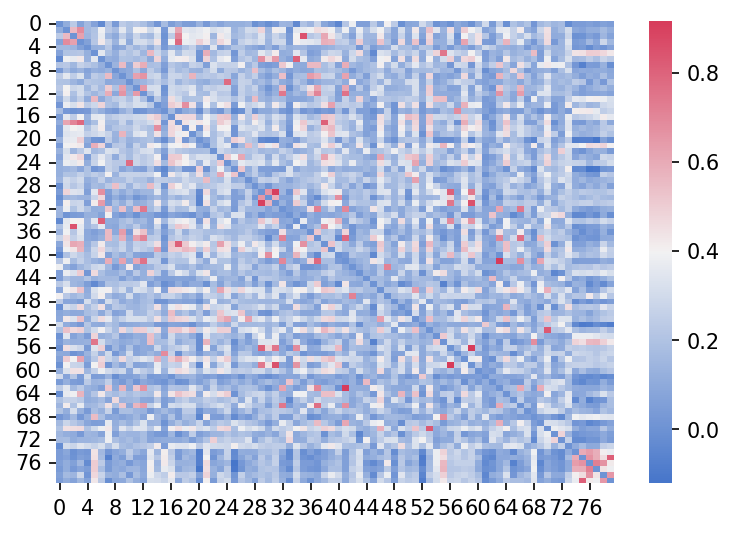

In [73]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=s_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)
#plt.savefig('skill_heatmap_before.png')

In [74]:
# Generating similarity binary group
s_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if s_matrix[i][j] > 0.4:
            triple_item = [i,j]
            s_triple_list.append(triple_item)
            triple_item = [j,i]
            s_triple_list.append(triple_item)
len(s_triple_list) #:1548

1548

In [75]:
s_triple_df = pd.DataFrame(s_triple_list, columns=['Subject','Object'])

## 5-2 Analysis of Co-occurrence of Knowledge Points

In [76]:
p_group_list = []
for key, value in problem_skill_group_dic.items():
    coo_list = value
    if len(coo_list) >= 2:
        p_group_list.append(coo_list) #同时出现在一道题目的多个知识点id的组合列表【共现列表】
len(p_group_list) #:67

67

In [77]:
# Co-occurrence matrix
mx_size = len(kc_get_NAME) #mx_size ： 80

m_matrix = np.zeros((mx_size, mx_size))
for p_group in p_group_list:
    for i in range(0,len(p_group)):
        for j in range(i+1,len(p_group)):
            m_matrix[p_group[i],p_group[j]] += 1;
            m_matrix[p_group[j],p_group[i]] += 1;

<Axes: >

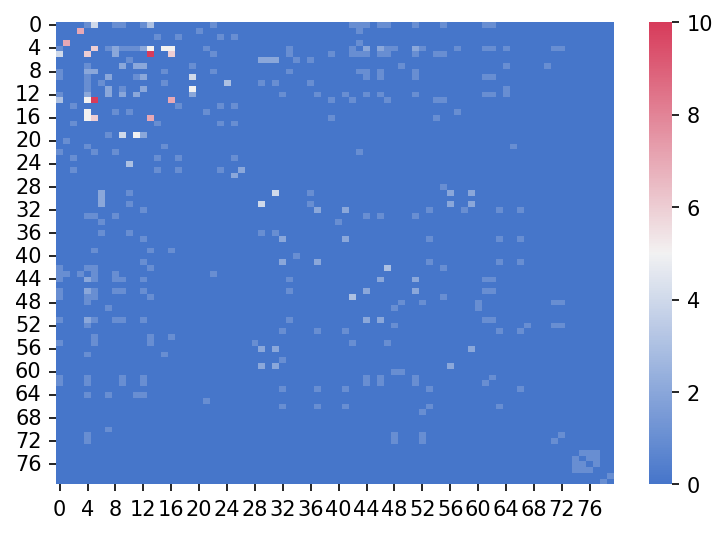

In [78]:
# Heat map analysis
plt.figure(dpi=150, figsize=(6, 4))
sns.heatmap(
    data=m_matrix,
    cmap=sns.diverging_palette(255, 5, as_cmap=True),
)
#plt.savefig('skill_group_heatmap.png')

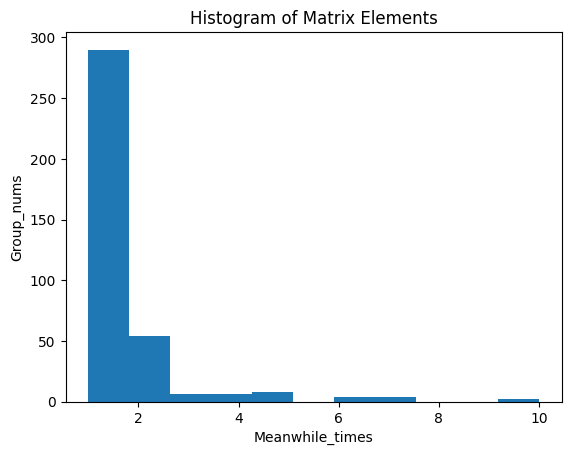

In [79]:
# Histogram analysis
freq_list = []
for line in m_matrix:
    for item in line:
        if item > 0:
            freq_list.append(item)
freq_array = np.array(freq_list)
plt.hist(freq_array, bins=11)
plt.xlabel('Meanwhile_times')
plt.ylabel('Group_nums')
plt.title('Histogram of Matrix Elements')
plt.savefig('skill_meanwhile_frequency.png')
plt.show()

In [80]:
# Generating binary group
m_triple_list = []
for i in range(mx_size):
    for j in range(mx_size):
        if m_matrix[i][j] > 0:
            triple_item = [i,j]
            m_triple_list.append(triple_item)
            triple_item = [j,i]
            m_triple_list.append(triple_item)
len(m_triple_list) #:748

748

In [81]:
m_triple_df = pd.DataFrame(m_triple_list, columns=['Subject','Object'])

## 2-3 Knowledge graph file

In [82]:
# s_triple_df
# m_triple_df
# 'Subject','Object'

In [83]:
kg_df = pd.concat([s_triple_df, s_triple_df], ignore_index=True)
kg_df = kg_df.drop_duplicates()
kg_df.head(3)
#kg_df.shape #:(774, 2)

,Subject,Object
0,0,47
1,47,0
2,1,2


In [85]:
# Save
kg_df.to_csv('C:/Users/Lenovo/Desktop/Static_s15_p2_graph.txt', sep='\t', index=False, header=False) #[change to your own path]